In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
import random
from math import sin, cos, sqrt, atan2, radians
from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
assert egrid.shape == (406, 964)
import time

In [ ]:
# Set the size bins
max_diameter=330
diam_bins = [5, 10, 50, 100]
diam_labs = ['005', '005-009', '010-050', '050-100', '100+']
diam_range = {'005':[1,5],'005-009':[5,9],'010-050':[10,50],'050-100':[50,100],'100+':[100,max_diameter]}
lambda_start = {'005':1,'005-009':1.1,'010-050':1.2,'050-100':1.4,'100+':1.8}
lambda_end = {'005':2,'005-009':4,'010-050':8,'050-100':16,'100+':32}

In [ ]:
# Make dictionary with size bins and frequency
with open('sfd.csv', 'r') as f:
    freqs = pd.read_csv(f).groupby('D').sum()
los_dict = {i:0 for i in diam_labs}
his_dict = {i:0 for i in diam_labs}
for i in freqs.index.values:
    for j in range(len(diam_bins)):
        if i < diam_bins[j]:
            los_dict[diam_labs[j]] += freqs.loc[i,'low']
            his_dict[diam_labs[j]] += freqs.loc[i,'high']
            break
        elif i >= diam_bins[-1]:
            los_dict[diam_labs[-1]] += freqs.loc[i,'low']
            his_dict[diam_labs[-1]] += freqs.loc[i,'high']
            break
df_freq = pd.DataFrame.from_dict({'high':his_dict, 'low':los_dict, 
                                  'lambda_start':lambda_start, 'lambda_end':lambda_end})
df_freq['frequency_factor'] = [0.1,0.2,0.3,0.6,0.8]
df_freq

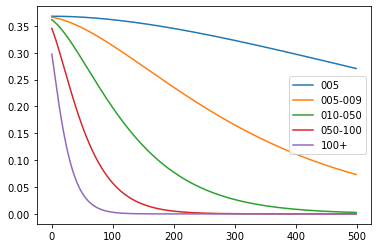

total impacts 2078170.0
impacts by diameter {'005': 1924351.0, '005-009': 114070.0, '010-050': 36423.0, '050-100': 2883.0, '100+': 443.0}
fraction of total {'005': 0.93, '005-009': 0.05, '010-050': 0.02, '050-100': 0.0, '100+': 0.0}


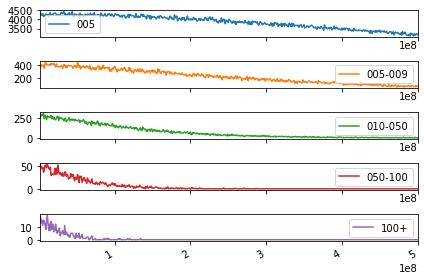

,high,low,lambda_start,lambda_end,frequency_factor,total
005,16950000,1695000,1.0,2,0.000086,1924351.0
005-009,855000,85500,1.1,4,0.000919,114070.0
010-050,146100,14610,1.2,8,0.001338,36423.0
050-100,8700,870,1.4,16,0.006971,2883.0
100+,3050,305,1.8,32,0.016792,443.0


In [4]:
t_total=500

fivehundredmillion = 500000000
freq_factor = fivehundredmillion/t_total

not_converged=True
while not_converged:

    pp = {x:np.zeros(t_total) for x in diam_labs}
    l = {x:np.linspace(y,z,t_total) for x,y,z in zip(diam_labs,df_freq['lambda_start'],df_freq['lambda_end'])}

    for D in diam_labs:
        pp[D] = l[D]*np.exp(-l[D])

    df = pd.DataFrame(data=pp)
    hits = {d:np.zeros(t_total) for d in diam_labs}

    # Main loop through time. Calculate the total number of impacts of each diameter at each time step
    for t in range(0,t_total):
        for D in diam_labs:
            hits[D][t] = np.floor(np.random.poisson(pp[D][t] / df_freq.loc[D, 'frequency_factor']))


    total_sum = np.sum([hits[d] for d in diam_labs])
    sums = {d:np.sum(hits[d]) for d in diam_labs}
    frac = {d:np.round(np.sum(hits[d])/total_sum,2) for d in diam_labs}
    
    for d in diam_labs:
        df_freq.loc[d,'total']=sums[d]
    
    good_numbers = 0
    for d in diam_labs:
        if df_freq.loc[d,'total'] < df_freq.loc[d,'low']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*random.random()
        elif df_freq.loc[d,'total'] > df_freq.loc[d,'high']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*(1+random.random())
        else:
            good_numbers+=1
    if good_numbers == df_freq.shape[0]:
        not_converged = False
    
    
    
plt.plot(df)
plt.legend(df.columns.values)
plt.show()
print('total impacts', total_sum)
print('impacts by diameter', sums)
print('fraction of total', frac)
plot_time = np.linspace(0,fivehundredmillion,t_total+1)[1:]
df = pd.DataFrame(data=hits, index=plot_time)
df.plot(subplots=True)
plt.tight_layout()
plt.show()
df_freq

In [5]:
# approximate radius of earth in km
def distance(lat1,lat2,lon1,lon2):
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    return(distance) #km

In [6]:
# def re_bin_sio2(temp_state, s_min=34, s_max=70, ds=2):
#     for s in range(s_min,s_max,ds):
#         if temp_state<=s:
#             return s
#         elif temp_state>=s_max:
#             return s_max
#         else:
#             continue

In [9]:
class IMPAaCS:

    """
    Last update: May 28th 2021 @ 7:19PM Central Time, with Jordan 
    
    Dynamic geospatial model of IMPaCS, 
    using the size-frequency distribution of impacts scaled from the lunar surface, 
    we generate the volume and abundance of this enriched crust on Earth’s surface 
    during the Hadean to determine how rapidly it evolved.
    """
    
    impact_test_id = str(round(-87.5726,4))+' '+str(round(33.2921,4))
    
    def __init__(self, egrid, 
                 verbose=False,
                 max_depth_of_impact_melt=330,
                 ensemble = 0,
                 primitive_initial_state=45,
                 fraction_upper_layer = 2/3,
                 target_SiO2 = 62.58,     # From sudbury
                 upper_SiO2 = 68.71,      # From sudbury
                 n_layers_impact_melt = 2,
                 z_discretized_km = int(2),
                 proportion_melt_from_impact = 1/3,
                 sim_time=0,
                 x_lims = [-180, 180], y_lims = [-45, 45]):
        self.egrid = egrid
        self.verbose=verbose
        self.ensemble=ensemble
        self.primitive_initial_state = primitive_initial_state
        self.max_depth_of_impact_melt = max_depth_of_impact_melt
        self.fraction_upper_layer = fraction_upper_layer        # d_upper / Mi (from Sudbury)
        self.fraction_lower_layer = 1-self.fraction_upper_layer # d_lower / Mi (from Sudbury)
        self.n_layers_impact_melt = n_layers_impact_melt
        self.target_SiO2 = target_SiO2 # From sudbury
        self.upper_SiO2 = upper_SiO2  # From sudbury
        self.z_discretized_km = z_discretized_km
        self.proportion_melt_from_impact = proportion_melt_from_impact
        self.average_target = self.primitive_initial_state
        self.average_target_list = [self.primitive_initial_state]
        self.top_layer_at_test_cell = [self.primitive_initial_state]
        self.average_test_target_list = [self.primitive_initial_state]
        self.n_x = self.egrid.londim.shape[0]
        self.n_y = self.egrid.latdim.shape[0]
        self.sim_time=sim_time
        
        self.count_test_hits = 0
        self.grid_cell_state = {}
        self.impacted_grid_cells = []
        self.impactors_at_test_cell = [0]
        self.test_time = [0]
        
        self.state_prep()
        
        self.sample_percents = {}
        self.x_lims=x_lims
        self.y_lims=y_lims
        
    #--------------------------------------------------------------------------------------------------
    def update(self, impact_loc, impactor_diameter, sim_time=0):
        self.sim_time = sim_time
        self.impact_dimensions(impactor_diameter)
        self.find_the_grid(impact_loc)
        self.get_average_target(impactor_diameter)
        self.loop_impact_grid(impactor_diameter)
        
    #--------------------------------------------------------------------------------------------------
    #---- THIS IS THE MAIN CODE -------------------- THIS IS THE MAIN CODE ----------------------------
    #--------------------------------------------------------------------------------------------------
    def state_dynamics(self, impactor_diameter, grid_cell_id):
        """
        This is the critical component of this model
        This function will change the chemical makeup of each grid cell
            according to the chemical theory put forward by Faltys-Wielicki [2021]
        """
        
        #####      DYNAMIC FACTORS       ############################
        depth_of_impact_melt = impactor_diameter * self.proportion_melt_from_impact # D/3

        #Vertical discretization.
        melt_layers = int(depth_of_impact_melt / self.z_discretized_km)

        lower_layer  = range(int(round(self.fraction_upper_layer * melt_layers,2)), melt_layers)
        upper_layer  = range(0, int(round(self.fraction_upper_layer * melt_layers,2)))

        fracionated_melt = depth_of_impact_melt * self.fraction_upper_layer #Units: km

        fractionation_factor = 1 - (self.target_SiO2 / self.upper_SiO2)

        #####      DO THE DYANMICS       #############################
        # Set lower layer to primitive initial state.  
        for i in lower_layer:
            self.grid_cell_state[grid_cell_id][i] = self.primitive_initial_state

        # Impact melt portion  (Upper)
        for i in upper_layer:
            self.grid_cell_state[grid_cell_id][i] = self.average_target / (1 - fractionation_factor)

        # Weighted average of upper    
        wt_sio2_upper = self.grid_cell_state[grid_cell_id][0]

        # Lower of impact melt portion
        for i in lower_layer:
            numerator = self.average_target-(self.fraction_upper_layer * wt_sio2_upper)
            self.grid_cell_state[grid_cell_id][i] = numerator / self.fraction_lower_layer

        for i in range(melt_layers):
            self.grid_cell_state[grid_cell_id][i] = np.round(self.grid_cell_state[grid_cell_id][i],1)
    
    #--------------------------------------------------------------------------------------------------    
    def state_prep(self):
        total_layers = int(self.max_depth_of_impact_melt / self.z_discretized_km)
        for ilon in self.egrid.londim:
            for ilat in self.egrid.latdim:
                grid_cell_id = str(round(ilon,4))+' '+str(round(ilat,4))
                self.grid_cell_state[grid_cell_id] = np.ones(total_layers) * self.primitive_initial_state
    
    #--------------------------------------------------------------------------------------------------    
    def get_average_target(self, impactor_diameter):
        average_target = 0
        for grid_cell in self.impacted_grid_cells:
            grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))
            ### If the grid cell has not been hit yet, it is the initial primitive value
            if grid_cell_id in self.grid_cell_state.keys():
                average_target += np.sum(self.grid_cell_state[grid_cell_id][:self.z_layers])
            else:
                average_target += self.primitive_initial_state * self.z_layers
        self.average_target = average_target/(len(self.impacted_grid_cells) * self.z_layers)
        
    #--------------------------------------------------------------------------------------------------    
    def find_the_grid(self, impact_loc):
        self.impacted_grid_cells = [] # first reset the impacted grid cells, then fill them up
        Dmin=10000000
        for ilon in self.egrid.londim:
            for ilat in self.egrid.latdim:
                D = distance(impact_loc[0],ilat,impact_loc[1],ilon)
                if D < Dmin:
                    Dmin = D
                if D <= self.crator_radius:
                    self.impacted_grid_cells.append([ilon, ilat])
        if len(self.impacted_grid_cells) < 1:
            if self.verbose:
                print("Warning. There are no grids impacted!")
                print('Dmin', Dmin, 'crator radius', self.crator_radius, 'impact location', impact_loc)
            for ilon in self.egrid.londim:
                for ilat in self.egrid.latdim:
                    D = distance(impact_loc[0],ilat,impact_loc[1],ilon)
                    if D == Dmin:
                        self.impacted_grid_cells.append([ilon, ilat])
                        if self.verbose:
                            print('impacting grid cell', [ilon, ilat])

    #--------------------------------------------------------------------------------------------------    
    def loop_impact_grid(self, impactor_diameter):
        for grid_cell in self.impacted_grid_cells:
            grid_cell_id = str(round(grid_cell[0],4))+' '+str(round(grid_cell[1],4))

            ################      DO THE DYANMICS       #############################
            self.state_dynamics(impactor_diameter, grid_cell_id)

            self.test_one_grid_cell(grid_cell_id, impactor_diameter)
    #--------------------------------------------------------------------------------------------------    
    def impact_dimensions(self, impactor_diameter):
            # The impact crator is 10*Diameter, so the radius is half that
            self.crator_diameter = 10*impactor_diameter
            self.crator_radius = self.crator_diameter/2
            self.z_layers = int(np.ceil(impactor_diameter / self.z_discretized_km))

    #--------------------------------------------------------------------------------------------------    
    def test_one_grid_cell(self, grid_cell_id, impactor_diameter):
        ##### Testing one cell:
        if grid_cell_id == self.impact_test_id:
            self.count_test_hits+=1
            self.test_time.append(self.sim_time)
            self.impactors_at_test_cell.append(impactor_diameter)
            self.average_test_target_list.append(self.average_target)
            self.top_layer_at_test_cell.append(self.grid_cell_state[self.impact_test_id][0])

    #--------------------------------------------------------------------------------------------------
    def re_bin_sio2(self, temp_state, s_min=34, s_max=70, ds=2):
        """
            Functionto place the mean SiO2 into the proper bin for distribution.
        """
        for s in range(s_min,s_max,ds):
            if temp_state<=s:
                return s
            elif temp_state>=s_max:
                return s_max
            else:
                continue

    # ---------------------------------------------------------------------------------------------
    def plot_map_and_bar(self, save_figure=False, plot_figure=False, fig_path='./',
                         plot_x_lims = [-180, 180],
                         plot_y_lims = [-45, 45]):
        
        """
            Function for plotting 2D map of SiO2 States.
            Function inputs:
                save_figure=False
                plot_figure=False
                fig_path='./'
        """
        
        if not plot_figure and not save_figure:
            print('not plotting figure')
            return

        z = np.zeros([self.n_x, self.n_y])
        bar_list = []
        for i, ilon in enumerate(self.egrid.londim):
            for j, ilat in enumerate(self.egrid.latdim):
                grid_cell = str(round(ilon,4))+' '+str(round(ilat,4))
                temp_state = np.mean(self.grid_cell_state[grid_cell][0:2])
                temp_state = self.re_bin_sio2(temp_state)
                z[i, j] = temp_state
        
        X, Y = np.meshgrid(self.egrid.londim, self.egrid.latdim)
        
        fig = plt.figure(figsize=(15, 5))

        grid = plt.GridSpec(1, 7, wspace = .1, hspace = .1)
        plt.subplots_adjust(wspace= 0.1, hspace= 0.1)

        plt.subplot(grid[0, :6])
        
        levels = np.arange(34, 70, 2)
        cmap = cm.jet
        cs = plt.contourf(X, Y, np.transpose(z), levels, cmap=cm.get_cmap(cmap, len(levels) - 1)) 
        cbar = fig.colorbar(cs, ticks=range(34,70,2))

        plt.title('Surface SiO2 content at {}myr'.format(int(self.sim_time/1000000)))
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.xlim(plot_x_lims)
        plt.ylim(plot_y_lims)
        plt.xticks(np.arange(plot_x_lims[0], plot_x_lims[1], 10))
        
        plt.subplot(grid[0, 6])
        plt.bar(list(self.sample_percents.keys()), list(self.sample_percents.values()), width=1.2)
        plt.xlim([35,70])
        plt.ylim([0,40])
        plt.xlabel('Surface SiO2 content')
        plt.ylabel('Percent surface area')
        plt.xticks(np.arange(35, 75, 5))
        if save_figure:
            plt.savefig(fig_path+'{}myr.png'.format(int(self.sim_time/1000000)), 
                    bbox_inches='tight', dpi = 100)
        if plot_figure:
            plt.show()
        plt.close()
        
    # ---------------------------------------------------------------------------------------------
    def do_sample_percents(self, x_lims = [-180, 180], y_lims = [-45, 45], n_layers=2):
        
        """
            Function Summarizing and saving SiO2 percentages in a sample region.
            Function inputs:
                plot_x_lims = Limits of longitude for SiO2 sample
                plot_y_lims = Limits of latitude for SiO2 sample
                n_layers = number of discretized layers to include in the average.
        """
        
        z = np.zeros([self.n_x, self.n_y])
        bar_list = []
        for i, ilon in enumerate(self.egrid.londim):
            for j, ilat in enumerate(self.egrid.latdim):
                grid_cell = str(round(ilon,4))+' '+str(round(ilat,4))
                temp_state = np.mean(self.grid_cell_state[grid_cell][0:2])
                temp_state = self.re_bin_sio2(temp_state)
                z[i, j] = temp_state
                
                # Don't analyze anything outside the plot bounds
                if float(grid_cell.split(" ")[1]) < y_lims[0]:
                    continue
                elif float(grid_cell.split(" ")[1]) > y_lims[1]:
                    continue
                elif float(grid_cell.split(" ")[0]) < x_lims[0]:
                    continue
                elif float(grid_cell.split(" ")[0]) > x_lims[1]:
                    continue
                else:
                    mean_sio2 = np.mean(self.grid_cell_state[grid_cell][0:2])
                    if not np.isnan(mean_sio2):
                        bar_list.append(self.re_bin_sio2(mean_sio2))
        
        bar_list = [x for x in bar_list if x != None]
        
        X, Y = np.meshgrid(self.egrid.londim, self.egrid.latdim)
        bar_data = {}
        for u in np.unique(bar_list):
            bar_data[u] = 100*bar_list.count(u)/len(bar_list)

        self.sample_percents = bar_data

In [23]:
impact_boundz=20
[-impact_boundz, impact_boundz]
Impc = IMPAaCS(egrid, max_depth_of_impact_melt=330, 
               x_lims = [-impact_boundz, impact_boundz], y_lims = [-impact_boundz, impact_boundz])
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    start_time = time.time()
    print('time', it)
    for d in diam_labs:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            if np.abs(impact_lat) > impact_boundz:
                continue
            if np.abs(impact_lon) > impact_boundz:
                continue
            impact_loc = [impact_lat, impact_lon]
            impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            Impc.update(impact_loc, impactor_diameter, t)
            
    Impc.do_sample_percents(Impc.x_lims,Impc.x_lims,n_layers=2)
    
    if it == 0:
        percent_df = pd.DataFrame(Impc.sample_percents, index=[it])
    else:
        percent_df = percent_df.append(Impc.sample_percents, ignore_index=True)
    print(Impc.sample_percents)
            
#    break
    # make a map of the results at this time
#     Impc.plot_map_and_bar(plot_figure=True, plot_x_lims = [-20, 20], plot_y_lims = [-20, 20])
    print("elapsed time: {}".format(time.time() - start_time))
    
#     if it > 1:
#         break

time 0
{44: 0.07380568974771873, 46: 91.57944176060118, 50: 8.3467525496511}
elapsed time: 109.7942967414856
time 1
{44: 0.14090177133655393, 46: 74.69806763285024, 50: 25.161030595813205}
elapsed time: 119.38002228736877
time 2
{44: 0.07380568974771873, 46: 64.30488459473966, 50: 34.84970477724101, 54: 0.7716049382716049}
elapsed time: 105.01434779167175
time 3
{44: 0.07380568974771873, 46: 46.81964573268921, 50: 50.55018786902845, 52: 0.6575415995705851, 54: 1.1406333870101986, 56: 0.7581857219538379}
elapsed time: 129.70510959625244
time 4
{44: 0.15432098765432098, 46: 44.524959742351044, 48: 0.05367686527106817, 50: 52.89855072463768, 52: 0.6575415995705851, 54: 0.95276435856146, 56: 0.7313472893183038, 58: 0.026838432635534086}
elapsed time: 103.33974742889404
time 5
{44: 0.24154589371980675, 46: 40.29790660225443, 48: 0.16774020397208803, 50: 55.803811057434245, 52: 0.630703166935051, 54: 0.95276435856146, 56: 1.8518518518518519, 58: 0.05367686527106817}
elapsed time: 103.6598422

KeyboardInterrupt: 

In [25]:
percent_df

,44,46,50
0,0.073806,91.579442,8.346753


In [ ]:
s_min=34
s_max=70
ds=1
for s in range(s_min,s_max,ds):
    print(s)

In [ ]:
plt.plot(Impc.test_time, Impc.average_test_target_list)
plt.plot(Impc.test_time, Impc.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(Impc.test_time, Impc.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

In [ ]:
n_x = egrid.londim.shape[0]
n_y = egrid.latdim.shape[0]
z = np.zeros([n_x, n_y])
for i, ilon in enumerate(egrid.londim):
    for j, ilat in enumerate(egrid.latdim):
        grid_cell = str(round(ilon,4))+' '+str(round(ilat,4))
        z[i, j] = np.mean(Impc.grid_cell_state[grid_cell][0:2])

X, Y = np.meshgrid(egrid.londim, egrid.latdim)

In [ ]:
z

In [ ]:
# fig1, ax1 = plt.subplots(constrained_layout=True)
# fig1.clim(30, 65)
# cs = ax1.contourf(X, Y, np.transpose(z), vmin=30, vmax=65)
# cs.set_clim(30, 65)
# fig1.colorbar(cs)
# cbar = fig1.colorbar(cs, boundaries=[30,65], cmap = cs)
# cbar.ax.set_ylabel('percent SiO2')
#cbar.set_clim(30,65)
plt.contourf(X, Y, np.transpose(z), vmin=30, vmax=65)
plt.clim(vmin=30, vmax=65)
cb = plt.colorbar()
cb.set_clim(vmin=30, vmax=65)
plt.title('top 6-meter sio2 at time {}myr'.format(int(Impc.sim_time/1000000)))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()
plt.close()

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid)
I.__init__(egrid)
impact_test_diameters = [330, 73, 16, 10, 5, 2, 330, 73, 16, 10, 5, 2]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 33.2921                             # Test scenario
                impact_lon = -87.5726                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter, t)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

# 10 X impacts teste cast

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid)
I.__init__(egrid)
impact_test_diameters = [330, 330, 330, 330, 330, 330, 330, 330, 330, 330,
                         73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
                         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
                         10, 10,  10,  10,  10,  10,  10,  10,  10,  10, 
                         5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                         2, 2, 2, 2, 2, 2, 2, 2, 2, 2,]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 33.2921                             # Test scenario
                impact_lon = -87.5726                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter, t)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()